In [9]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math
import os
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [11]:
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [12]:
symbol = "BZ=F"
start_date = "2011-06-13"
end_date = "2025-06-25"

df_raw = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]
df_raw.dropna(inplace=True)

emb = pd.read_csv('embeddings_feature_distilbert-base-uncased.csv', parse_dates=['date']).set_index('date')
sent = pd.read_csv('daily_sent.csv', parse_dates=['Date']).set_index('Date')

emb_aligned = emb.reindex(df_raw.index).ffill().bfill()
sent_aligned = sent.reindex(df_raw.index).ffill().bfill()

df_raw['SENT_1'] = emb_aligned['embedding_3d_1_mean']
df_raw['SENT_2'] = emb_aligned['embedding_3d_2_mean']
df_raw['SENT_3'] = emb_aligned['embedding_3d_3_mean']
df_raw['cosine_sim'] = emb_aligned['cosine_sim']
df_raw['drift'] = emb_aligned['drift']
df_raw['drift_velocity'] = emb_aligned['drift_velocity']
df_raw['drift_velocity_diff'] = emb_aligned['drift_velocity_diff']
df_raw['drift_acceleration'] = emb_aligned['drift_acceleration']
df_raw['var_3d_1'] = emb_aligned['embedding_3d_1_var_daily']
df_raw['var_3d_2'] = emb_aligned['embedding_3d_2_var_daily']
df_raw['var_3d_3'] = emb_aligned['embedding_3d_3_var_daily']
df_raw['sentiment'] = sent_aligned['avg_score']

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df_raw.values)

df_final = pd.DataFrame(scaled_values, columns=df_raw.columns, index=df_raw.index)

def create_sequences_multifeature_next_day(df, input_len=64, target_col='Close'):
    data = df.values
    col_idx = df.columns.get_loc(target_col)

    X, y = [], []
    for i in range(len(data) - input_len - 1):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len, col_idx])

    return np.array(X), np.array(y)

input_len = 64
X, y = create_sequences_multifeature_next_day(df_final, input_len=input_len, target_col='Close')

/tmp/ipython-input-12-1132694846.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]
[*********************100%***********************]  1 of 1 completed


In [13]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16, hidden_dim=64, num_layers=1):
        super().__init__()
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.encoder_fc = nn.Linear(hidden_dim * 2, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim, hidden_dim * 2)
        self.decoder_lstm = nn.LSTM(hidden_dim * 2, input_dim, num_layers, batch_first=True, bidirectional=False)

    def forward(self, x):
        enc_out, (h_n, c_n) = self.encoder_lstm(x)
        h_n_cat = torch.cat((h_n[-2], h_n[-1]), dim=1)
        z = self.encoder_fc(h_n_cat)

        dec_in = self.decoder_fc(z).unsqueeze(1).repeat(1, x.size(1), 1)
        dec_out, _ = self.decoder_lstm(dec_in)
        return dec_out, z

class TransformerPredictor(nn.Module):
    def __init__(self, latent_dim=16, nhead=2, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=latent_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(latent_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        out = self.fc_out(x)
        return out.squeeze(1)


In [14]:
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

In [15]:
def train_model(autoencoder, transformer, train_loader, val_loader, epochs=20, lr=1e-3):
    ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    tr_optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []
    val_maes, val_rmses = [], []

    for epoch in range(epochs):
        autoencoder.train()
        transformer.train()
        train_loss = 0

        for xb, yb in train_loader:
            yb = yb.squeeze(-1)
            ae_optimizer.zero_grad()
            tr_optimizer.zero_grad()

            out_ae, z = autoencoder(xb)
            loss_ae = criterion(out_ae, xb)

            y_pred = transformer(z)
            loss_tr = criterion(y_pred, yb)

            loss = loss_ae + loss_tr
            loss.backward()
            ae_optimizer.step()
            tr_optimizer.step()

            train_loss += loss.item()

        val_mse, val_mae, val_rmse, val_r2 = evaluate_model(autoencoder, transformer, val_loader)

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_mse)
        val_maes.append(val_mae)
        val_rmses.append(val_rmse)

        print(f"Epoch {epoch+1}/{epochs} Train Loss: {train_losses[-1]:.6f} Val MSE: {val_mse:.6f} Val MAE: {val_mae:.6f} Val RMSE: {val_rmse:.6f} Val R2: {val_r2:.6f}")

    return train_losses, val_losses, val_maes, val_rmses


def evaluate_model(autoencoder, transformer, data_loader):
    autoencoder.eval()
    transformer.eval()
    all_y_true = []
    all_y_pred = []
    with torch.no_grad():
        for xb, yb in data_loader:
            yb = yb.squeeze(-1)
            out_ae, z = autoencoder(xb)
            y_pred = transformer(z)
            all_y_true.append(yb.cpu().numpy())
            all_y_pred.append(y_pred.cpu().numpy())
    y_true = np.concatenate(all_y_true, axis=0)
    y_pred = np.concatenate(all_y_pred, axis=0)
    return compute_metrics(y_true, y_pred)


In [16]:
SEED = 42

g = torch.Generator()
g.manual_seed(SEED)

In [17]:
def prepare_dataloaders(X, y, dates, batch_size=64, split_ratios=(0.8, 0.1, 0.1)):
    num_samples = X.shape[0]
    train_end = int(num_samples * split_ratios[0])
    val_end = int(num_samples * (split_ratios[0] + split_ratios[1]))

    X_train, y_train, dates_train = X[:train_end], y[:train_end], dates[:train_end]
    X_val, y_val, dates_val = X[train_end:val_end], y[train_end:val_end], dates[train_end:val_end]
    X_test, y_test, dates_test = X[val_end:], y[val_end:], dates[val_end:]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def to_tensor_dataset(X_, y_):
        return TensorDataset(torch.tensor(X_, dtype=torch.float32).to(device),
                             torch.tensor(y_, dtype=torch.float32).to(device))

    train_loader = DataLoader(
        to_tensor_dataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    val_loader = DataLoader(
        to_tensor_dataset(X_val, y_val),
        batch_size=batch_size,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    test_loader = DataLoader(
        to_tensor_dataset(X_test, y_test),
        batch_size=batch_size,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )

    return train_loader, val_loader, test_loader, dates_train, dates_val, dates_test

In [18]:
batch_size = 64
dates_all = df_final.index.to_list()
train_loader, val_loader, test_loader, dates_train, dates_val, dates_test = prepare_dataloaders(
    X, y, dates_all, batch_size=batch_size, split_ratios=(0.8, 0.1, 0.1)
)

In [19]:
autoencoder = LSTMAutoencoder(input_dim=X.shape[2], latent_dim=64).to(device)
transformer = TransformerPredictor(latent_dim=64).to(device)

train_losses, val_losses, val_maes, val_rmses = train_model(autoencoder, transformer, train_loader, val_loader, epochs=20)

Epoch 1/20 Train Loss: 0.583778 Val MSE: 0.015808 Val MAE: 0.112596 Val RMSE: 0.125729 Val R2: -3.887292
Epoch 2/20 Train Loss: 0.074607 Val MSE: 0.012646 Val MAE: 0.100963 Val RMSE: 0.112456 Val R2: -2.909871
Epoch 3/20 Train Loss: 0.028398 Val MSE: 0.005339 Val MAE: 0.064417 Val RMSE: 0.073070 Val R2: -0.650751
Epoch 4/20 Train Loss: 0.024814 Val MSE: 0.002303 Val MAE: 0.038463 Val RMSE: 0.047986 Val R2: 0.288084
Epoch 5/20 Train Loss: 0.022812 Val MSE: 0.008621 Val MAE: 0.086360 Val RMSE: 0.092850 Val R2: -1.665408
Epoch 6/20 Train Loss: 0.020064 Val MSE: 0.004487 Val MAE: 0.058326 Val RMSE: 0.066987 Val R2: -0.387334
Epoch 7/20 Train Loss: 0.018467 Val MSE: 0.009380 Val MAE: 0.091484 Val RMSE: 0.096851 Val R2: -1.900078
Epoch 8/20 Train Loss: 0.017477 Val MSE: 0.002825 Val MAE: 0.044711 Val RMSE: 0.053150 Val R2: 0.126626
Epoch 9/20 Train Loss: 0.016782 Val MSE: 0.002492 Val MAE: 0.040840 Val RMSE: 0.049915 Val R2: 0.229687
Epoch 10/20 Train Loss: 0.016296 Val MSE: 0.004796 Val MAE

In [20]:
def evaluate_model_denormalized(autoencoder, transformer, data_loader, scaler, target_col_index=3):
    autoencoder.eval()
    transformer.eval()
    all_y_true = []
    all_y_pred = []
    with torch.no_grad():
        for xb, yb in data_loader:
            yb = yb.squeeze(-1)
            out_ae, z = autoencoder(xb)
            y_pred = transformer(z)
            all_y_true.append(yb.cpu().numpy())
            all_y_pred.append(y_pred.cpu().numpy())

    y_true = np.concatenate(all_y_true, axis=0)
    y_pred = np.concatenate(all_y_pred, axis=0)

    # Denormalizza
    min_val = scaler.data_min_[target_col_index]
    scale_val = scaler.data_range_[target_col_index]

    y_true_denorm = y_true * scale_val + min_val
    y_pred_denorm = y_pred * scale_val + min_val

    return compute_metrics(y_true_denorm, y_pred_denorm)


In [21]:
test_mse_denorm, test_mae_denorm, test_rmse_denorm, test_r2_denorm = evaluate_model_denormalized(
    autoencoder,
    transformer,
    test_loader,
    scaler,
    target_col_index=3
)

print(f"Test MSE (denorm): {test_mse_denorm:.6f}, Test MAE (denorm): {test_mae_denorm:.6f}, Test RMSE (denorm): {test_rmse_denorm:.6f}, Test R2 (denorm): {test_r2_denorm:.6f}")


Test MSE (denorm): 6.915619, Test MAE (denorm): 1.993858, Test RMSE (denorm): 2.629756, Test R2 (denorm): 0.861592


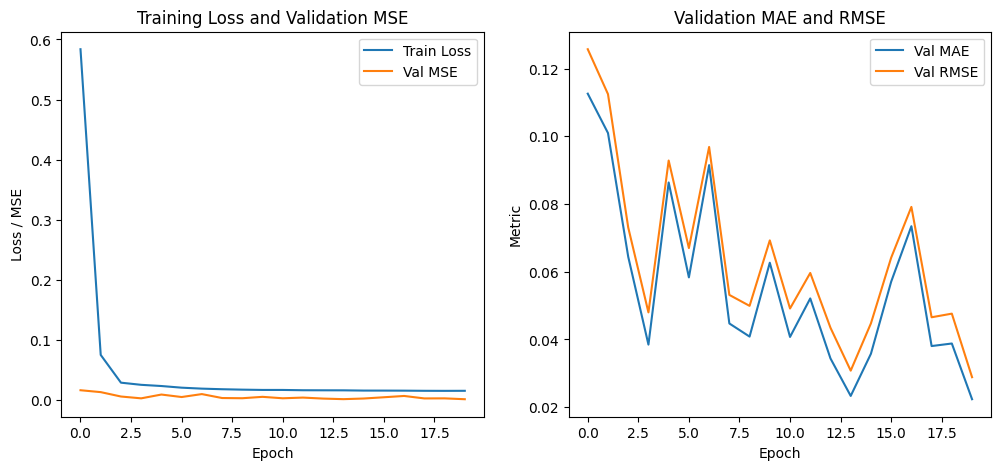

In [22]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss / MSE')
plt.legend()
plt.title('Training Loss and Validation MSE')

plt.subplot(1,2,2)
plt.plot(val_maes, label='Val MAE')
plt.plot(val_rmses, label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Validation MAE and RMSE')

plt.show()

In [23]:
def plot_predictions_with_dates(autoencoder, transformer, data_loader, scaler, dates, target_col_index=3):
    autoencoder.eval()
    transformer.eval()

    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for xb, yb in data_loader:
            yb = yb.squeeze(-1)
            out_ae, z = autoencoder(xb)
            y_pred = transformer(z)

            all_y_true.append(yb.cpu().numpy())
            all_y_pred.append(y_pred.cpu().numpy())

    y_true = np.concatenate(all_y_true, axis=0)
    y_pred = np.concatenate(all_y_pred, axis=0)


    min_val = scaler.data_min_[target_col_index]
    scale_val = scaler.data_range_[target_col_index]

    y_true_denorm = y_true * scale_val + min_val
    y_pred_denorm = y_pred * scale_val + min_val

    dates = dates[:len(y_true_denorm)]

    plt.figure(figsize=(14, 6))
    plt.plot(dates, y_true_denorm, label='True Values')
    plt.plot(dates, y_pred_denorm, label='Predictions')
    plt.title('Comparison of True Values and Predictions')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


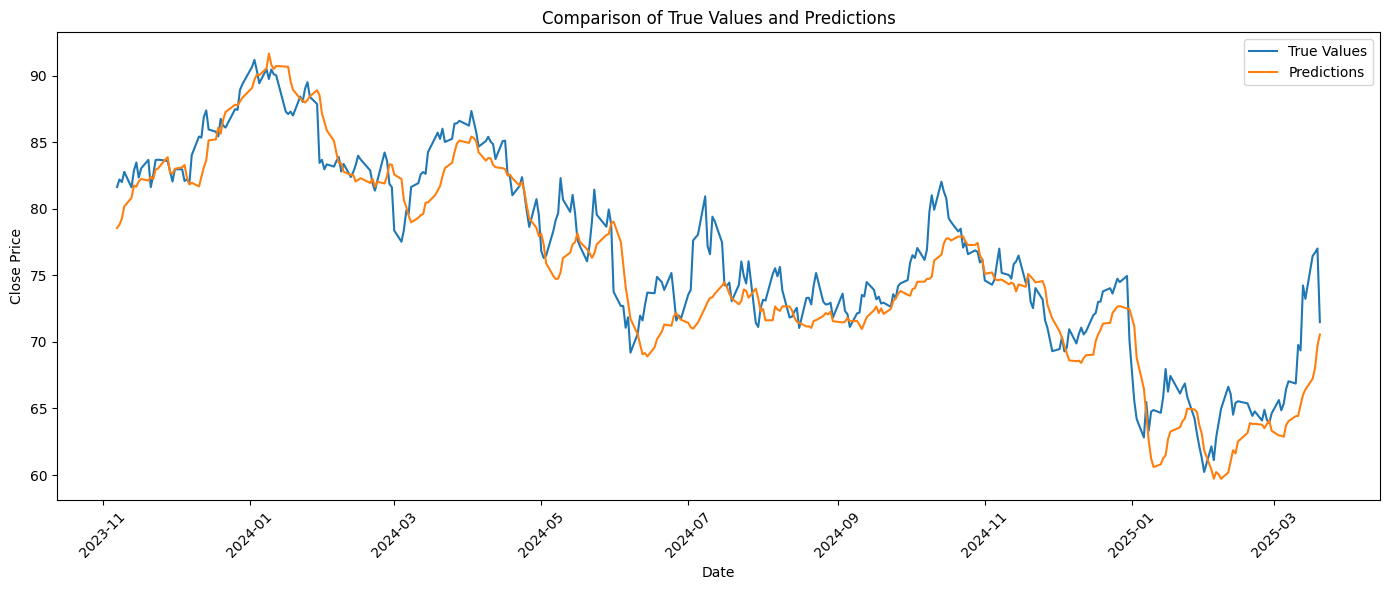

In [24]:
plot_predictions_with_dates(
    autoencoder=autoencoder,
    transformer=transformer,
    data_loader=test_loader,
    scaler=scaler,
    dates=dates_test,
    target_col_index=df_final.columns.get_loc('Close')
)


In [25]:
import plotly.graph_objects as go

def plot_predictions_interactive(autoencoder, transformer, data_loader, scaler, dates, target_col_index=3):
    autoencoder.eval()
    transformer.eval()

    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for xb, yb in data_loader:
            yb = yb.squeeze(-1)
            out_ae, z = autoencoder(xb)
            y_pred = transformer(z)

            all_y_true.append(yb.cpu().numpy())
            all_y_pred.append(y_pred.cpu().numpy())

    y_true = np.concatenate(all_y_true, axis=0)
    y_pred = np.concatenate(all_y_pred, axis=0)

    min_val = scaler.data_min_[target_col_index]
    scale_val = scaler.data_range_[target_col_index]

    y_true_denorm = y_true * scale_val + min_val
    y_pred_denorm = y_pred * scale_val + min_val

    dates = dates[:len(y_true_denorm)]

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=dates,
        y=y_true_denorm,
        mode='lines',
        name='Actual',
        line=dict(color='blue')
    ))

    fig.add_trace(go.Scatter(
        x=dates,
        y=y_pred_denorm,
        mode='lines',
        name='Predicted',
        line=dict(color='red')
    ))

    fig.update_layout(
        title='Brent Crude Oil – Actual vs Predicted',
        xaxis_title='Date',
        yaxis_title='Price (USD)',
        legend=dict(x=0, y=1),
        hovermode='x unified',
        template='plotly_white',
        width=900,
        height=500
    )

    fig.show()

In [26]:
plot_predictions_interactive(
    autoencoder=autoencoder,
    transformer=transformer,
    data_loader=test_loader,
    scaler=scaler,
    dates=dates_test,
    target_col_index=df_final.columns.get_loc('Close')
)